# Sparsity-driven deblending by inversion

**Authors: Nick Luiken, Matteo Ravasi - KAUST**

In this notebook, we perform deblending by inversion using a conventional approach (Abma, 2015):

$$
z_{\star} = arg\min_z \Vert BFz - d_b\Vert_2^2 + \lambda\Vert z\Vert_1, \quad d_b = Fz_{\star},
$$

where $F$ is a linear operator that performs a patched two-dimensional Fourier transform, and $z_{\star}$ is the solution in the Fourier domain that is ultimately transformed back to the original time-space domain of the seismic data. 

The results obtained in this notebook will be used to benchmark our proposed solution.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import segyio
import pylops
import matplotlib.gridspec as gridspec

from scipy.sparse.linalg import lobpcg as sp_lobpcg
from pylops import LinearOperator
from ssdeblend.pnp import Blending
from ssdeblend.utils import set_seed

## Data loading

To begin with, let's load the MobilAVO dataset. This data is stored in a commonly used format in geophysics, called [SEG-Y](https://en.wikipedia.org/wiki/SEG-Y). We are going to use the `segyio` library to do all the heavy lifting for us. 

As the data is stored in contiguous traces, we will rely on data analysis performed outside of this notebook to  arranged the dataset as a three dimensional tensor (or a cube), having the dimensions of the number of sources $n_s$, number of receivers $n_r$, and number of time samples $n_t$: $d_c(x_s, x_r, t)$.

Compared to `SSDeblending_CCG-denoising`, the dataset is here truncated for simplicity to $x_s=60$ and $x_t=1000$ to ensure that Fourier patching is performed over the entire domain.

In [2]:
# Load data
f = segyio.open('../data/MobilAVO.segy', ignore_geometry=True)
data = segyio.collect(f.trace[:])
data = data.reshape(1001, 120, 1500)

# Rearrange data
ns = 60 # number of sources
nr = 120 # number of receivers
nt = 1000 # number of time samples
dt = 0.004 # time sampling (sec)
dr = 25 # receiver sampling (m)
data = data[:ns, :, :nt]

# Define axes
t = dt * np.arange(nt)
xr = np.arange(0, nr*dr, dr)

At this point we design our blending strategy: $t_i=i \cdot T + \Delta t_i$. More precisely, we choose an overlap of 50% ($T=T_c/2$ where $T_c$ is the total time lenght of the unblended data) and a random dithering sampled from  $\Delta t_i \sim [-1, 1]$ seconds.

A matrix-free blending operator $B$ is then created using the PyLops[https://pylops.readthedocs.io/en/stable/] library.

In [3]:
# Create blending times
set_seed(42) # we set here the seed for reproducibility
overlap = 0.5
ignition_times = -1 + 2*np.random.rand(ns)
ignition_times[0] = 0 # set the first time dither to 0

# Blending operator
BlendingOp = Blending(nt, nr, ns, dt, overlap, ignition_times, nproc=20)

In [4]:
print('Ignition times:', ignition_times)

Ignition times: [ 0.          0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
 -0.88383278  0.73235229  0.20223002  0.41614516 -0.95883101  0.9398197
  0.66488528 -0.57532178 -0.63635007 -0.63319098 -0.39151551  0.04951286
 -0.13610996 -0.41754172  0.22370579 -0.72101228 -0.4157107  -0.26727631
 -0.08786003  0.57035192 -0.60065244  0.02846888  0.18482914 -0.90709917
  0.2150897  -0.65895175 -0.86989681  0.89777107  0.93126407  0.6167947
 -0.39077246 -0.80465577  0.36846605 -0.11969501 -0.75592353 -0.00964618
 -0.93122296  0.8186408  -0.48244004  0.32504457 -0.37657785  0.04013604
  0.09342056 -0.63029109  0.93916926  0.55026565  0.87899788  0.7896547
  0.19579996  0.84374847 -0.823015   -0.60803428 -0.90954542 -0.34933934]


We are now ready to blend our data ($d_b = B d_c$) and apply pseudo deblending to it ($d_{pd} = B^H d_b$)

In [5]:
blended_data = BlendingOp * data.ravel()
pseudodeblended_data = BlendingOp.H * blended_data

pseudodeblended_data = pseudodeblended_data.reshape(ns, nr, nt)
pseudodeblended_data_rearranged = np.transpose(pseudodeblended_data, (1, 0, 2)) # (nr, ns, nt)

Let's display one original shot gather, its corresponding pseudo deblended gather, and their equivalent in the CRG domain.

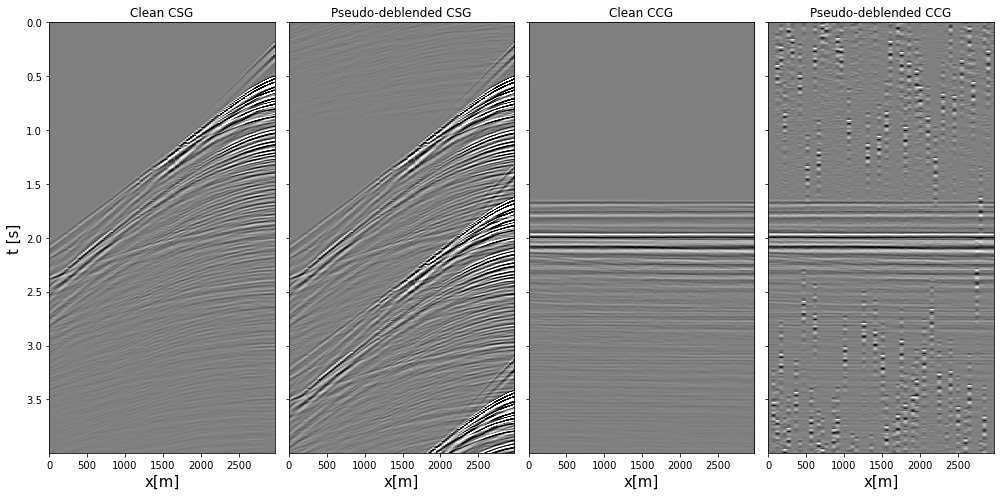

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(14, 7), sharey=True)
axs[0].imshow(data[30, :, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[0].set_xlabel('x[m]',fontsize=15)
axs[0].set_ylabel('t [s]',fontsize=15)
axs[0].set_title('Clean CSG')
axs[1].imshow(pseudodeblended_data[30, :, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[1].set_xlabel('x[m]',fontsize=15)
axs[1].set_title('Pseudo-deblended CSG')
axs[2].imshow(data[:, 30, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[2].set_xlabel('x[m]',fontsize=15)
axs[2].set_title('Clean CCG')
axs[3].imshow(pseudodeblended_data[:, 30, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray',
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[3].set_xlabel('x[m]',fontsize=15)
axs[3].set_title('Pseudo-deblended CCG')
plt.tight_layout()

## Patched Fourier transform

First of all, weleverage PyLops to create the patched Fourier transform to be used as sparsity transform in the deblending by inversion algorithm

In [7]:
# Create Patched Fourier transform
dimsd = (ns, nt)
nwin = (20, 80)
nover = (10, 40)
nop = (128, 128)
nop1 = (128, 65)
nwins = (5, 24)
dims = (nwins[0]*nop1[0], 
        nwins[1]*nop1[1])

Fop = pylops.signalprocessing.FFT2D(nwin, nffts=nop, real=True)
Sop1 = pylops.signalprocessing.Patch2D(Fop.H, dims, dimsd, nwin, nover, nop1,
                                      tapertype=None, 
                                      design=True)
Sop = pylops.signalprocessing.Patch2D(Fop.H, dims, dimsd, nwin, nover, nop1,
                                      tapertype='hanning',
                                      design=True)

# Combine Patched Fourier transforms acting on each CRG
SopDiag = []
for i in range(nr):
    SopDiag.append(Sop)
SopDiag = pylops.basicoperators.BlockDiag(SopDiag, nproc=20) 

  910  975 1040 1105 1170 1235 1300 1365 1430 1495], end:[  65  130  195  260  325  390  455  520  585  650  715  780  845  910
  975 1040 1105 1170 1235 1300 1365 1430 1495 1560]
 720 760 800 840 880 920], end:[  80  120  160  200  240  280  320  360  400  440  480  520  560  600
  640  680  720  760  800  840  880  920  960 1000]
  910  975 1040 1105 1170 1235 1300 1365 1430 1495], end:[  65  130  195  260  325  390  455  520  585  650  715  780  845  910
  975 1040 1105 1170 1235 1300 1365 1430 1495 1560]
 720 760 800 840 880 920], end:[  80  120  160  200  240  280  320  360  400  440  480  520  560  600
  640  680  720  760  800  840  880  920  960 1000]


Let's take a look at the action of this operator for a single CRG

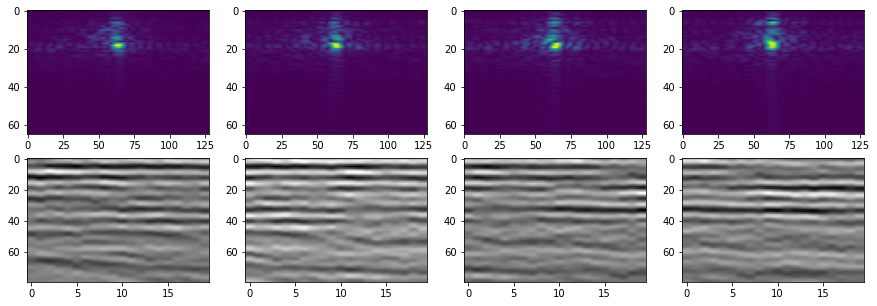

In [56]:
# Extract single CRG of unblended
crg = data[:, 40, :]

# Transform it to the Fourier domain
crg_fk = Sop1.H * crg.ravel()
crg_fk = crg_fk.reshape(dims)
crg_fk = crg_fk.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

# Display different patches and their equivalent fk spectrum
ix = 16
fig, axs = plt.subplots(2, 4, figsize=(15, 5))
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(crg_fk[i, ix]).T, axes=1))
    axs[0][i].axis('tight')
    axs[1][i].imshow(np.real((Fop.H * crg_fk[i, ix].ravel()).reshape(nwin)).T, cmap='gray')
    axs[1][i].axis('tight');

## Sparsity-promoting inversion

At this point we are ready to setup and perform our inversion using the FISTA algorithm

In [9]:
def callback(x, Sop, error, xtrue, shape):
    error.append(np.linalg.norm((Sop @ x) - xtrue.ravel())/np.linalg.norm(xtrue.ravel()))

In [10]:
# Apply the patched Fourier on the receiver gathers
Top = pylops.Transpose(dims=(nr, ns, nt), axes=(1, 0, 2))

# Construct the operator to apply the patched Fourier on the receiver gathers 
Op = BlendingOp * Top * SopDiag

# Compute the Lipschitz constant of the data misfit term (to be used to define the step size of FISTA)
Op1 = LinearOperator(Op.H * Op, explicit=False)
#X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
#maxeig = sp_lobpcg(Op1, X=X, maxiter=2, tol=1e-10)[0][0]
maxeig = 2.670960008433002 # precomputed
alpha = 1.0 / maxeig

In [11]:
niter = 200 # number of iterations
decay = (np.exp(-0.05*np.arange(niter)) + 0.2) / 1.2 # decaying step size

error = []
p_inv = pylops.FISTA(Op, blended_data.ravel(), niter, eps=5e0, alpha=alpha, decay=decay,
                       eigsiter=5, eigstol=5e-1, show=True, returninfo=True,
                       callback=lambda x: callback(x, SopDiag, error, 
                                                   data.transpose(1, 0, 2), 
                                                   shape=(nr, ns, nt)))[0]
data_inv = SopDiag * p_inv
data_inv = data_inv.reshape( nr, ns, nt)
data_inv = np.transpose(data_inv, (1, 0, 2))

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 3660000 rows and 119808000 cols
eps = 5.000000e+00	tol = 1.000000e-10	niter = 200
alpha = 3.743972e-01	thresh = 9.359930e-01
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate


/home/ravasim/miniconda3/envs/ssdeblend/lib/python3.9/site-packages/pylops/optimization/sparsity.py:1290: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = "%6g  %12.5e  %10.3e   %9.3e  %10.3e" % (


     1  -0.00000e+00   2.085e+09   2.732e+09   4.920e+04
     2  -0.00000e+00   9.301e+08   1.821e+09   2.224e+04
     3  -0.00000e+00   4.077e+08   1.455e+09   1.671e+04
     4  -0.00000e+00   1.873e+08   1.316e+09   1.212e+04
     5  -0.00000e+00   9.702e+07   1.257e+09   8.799e+03
     6  -0.00000e+00   5.993e+07   1.217e+09   6.658e+03
     7  -0.00000e+00   4.399e+07   1.179e+09   5.442e+03
     8  -0.00000e+00   3.649e+07   1.142e+09   4.821e+03
     9  -0.00000e+00   3.246e+07   1.105e+09   4.503e+03
    10  -0.00000e+00   2.989e+07   1.070e+09   4.314e+03
    11  -0.00000e+00   2.789e+07   1.038e+09   4.175e+03
    21  -0.00000e+00   1.461e+07   8.482e+08   3.179e+03
    31  -0.00000e+00   8.762e+06   7.670e+08   2.431e+03
    41  -0.00000e+00   5.845e+06   7.268e+08   1.906e+03
    51  -0.00000e+00   4.299e+06   7.039e+08   1.545e+03
    61  -0.00000e+00   3.450e+06   6.888e+08   1.297e+03
    71  -0.00000e+00   2.968e+06   6.777e+08   1.123e+03
    81  -0.00000e+00   2.686e+0

In [12]:
data_inv = SopDiag * p_inv
data_inv = data_inv.reshape( nr, ns, nt)
data_inv = np.transpose(data_inv, (1, 0, 2))

Finally we display the solutions for a number of sources and receivers

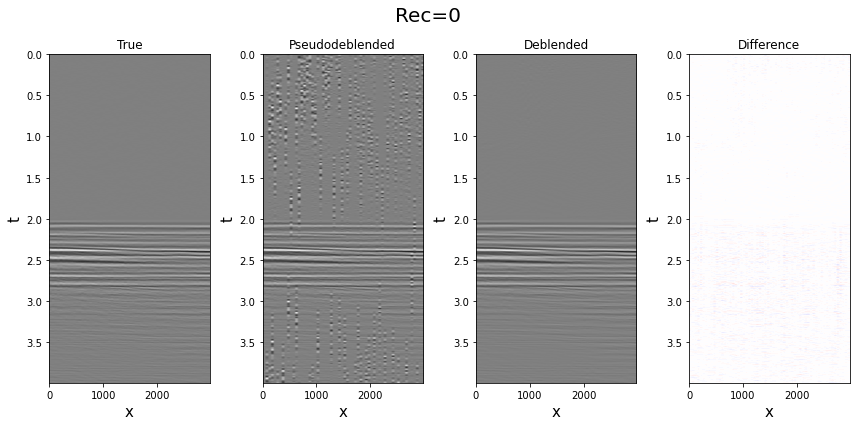

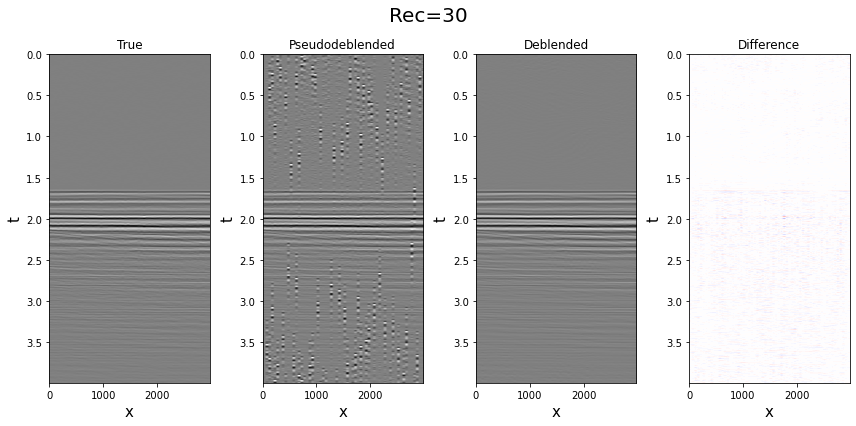

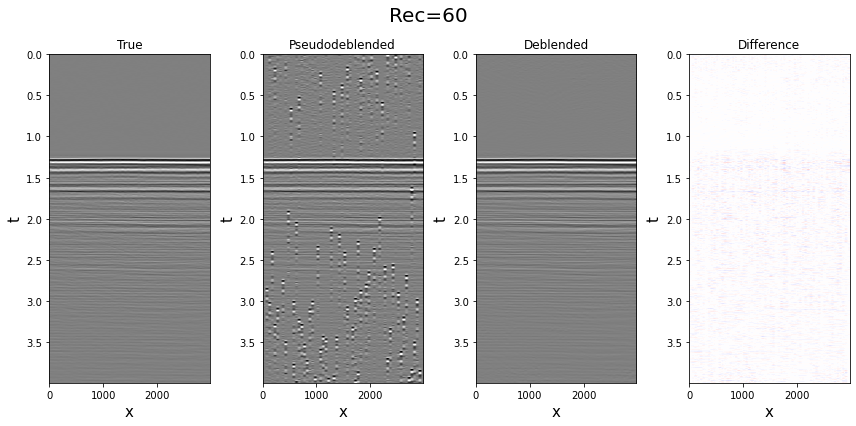

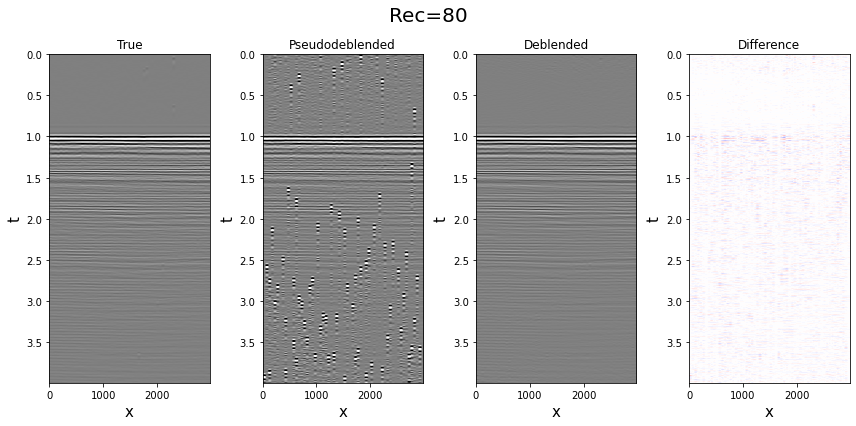

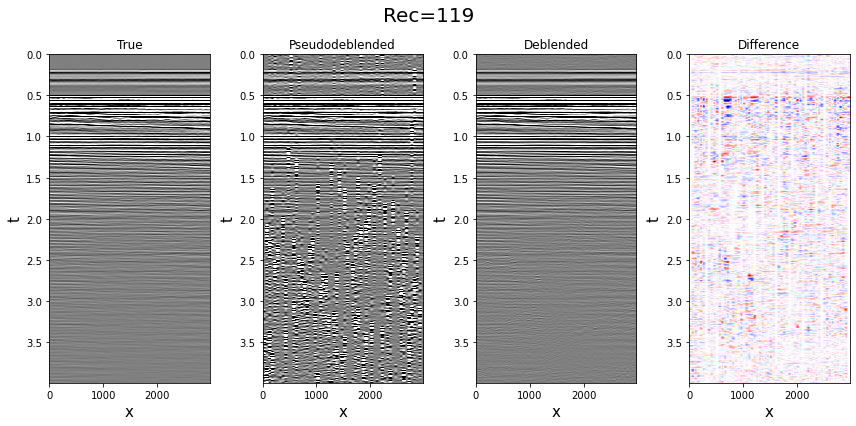

In [15]:
idxs = [0, nr//4, nr//2, 2*nr//3, nr-1]

for idx in idxs:
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle(f'Rec={idx}',fontsize=20)
    axs[0].imshow(data[:, idx, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[0].set_xlabel('x',fontsize=15)
    axs[0].set_ylabel('t',fontsize=15)
    axs[0].set_title('True')
    axs[1].imshow(pseudodeblended_data[:, idx, :].T.real, aspect='auto', 
                  vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[1].set_xlabel('x',fontsize=15)
    axs[1].set_ylabel('t',fontsize=15)
    axs[1].set_title('Pseudodeblended')
    axs[2].imshow(data_inv[:, idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[2].set_xlabel('x',fontsize=15)
    axs[2].set_ylabel('t',fontsize=15)
    axs[2].set_title('Deblended')
    axs[3].imshow((data[:, idx] - data_inv[:, idx]).T.real, 
                  aspect='auto', vmin=-100, vmax=100, cmap='seismic', 
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[3].set_xlabel('x',fontsize=15)
    axs[3].set_ylabel('t',fontsize=15)
    axs[3].set_title('Difference')
    plt.tight_layout();

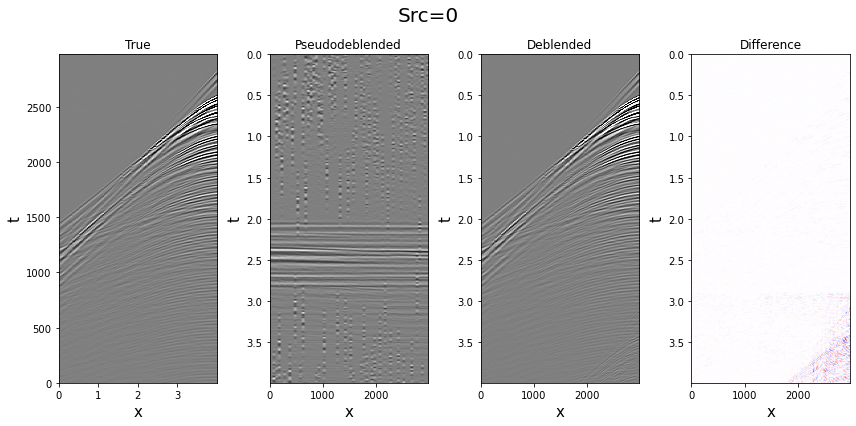

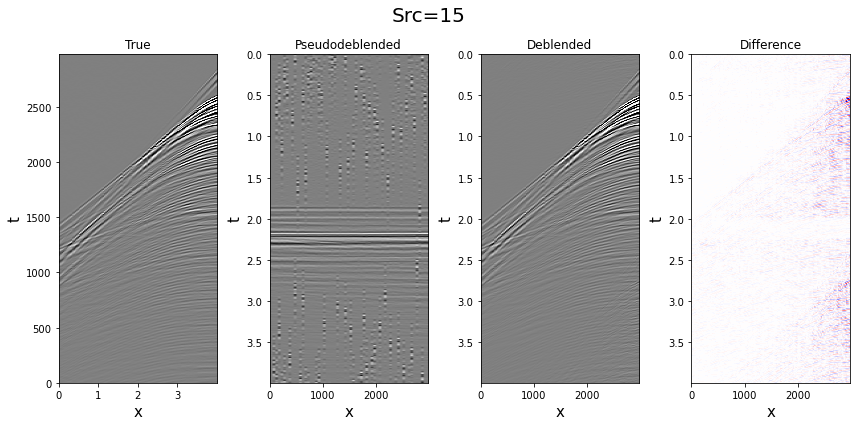

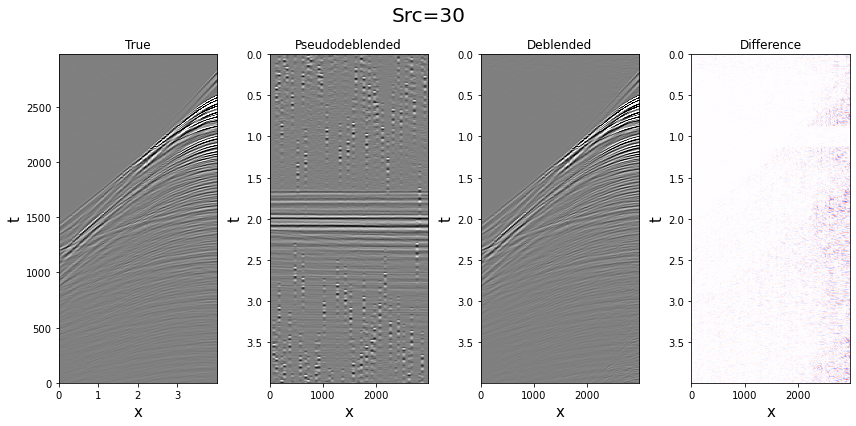

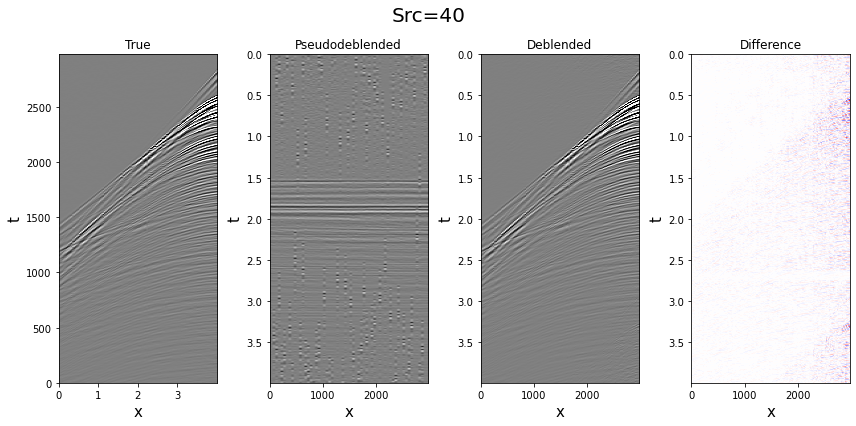

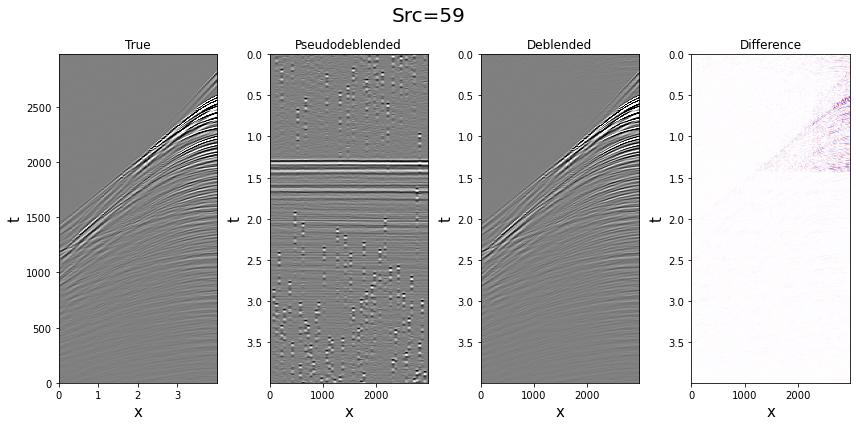

In [16]:
idxs = [0, ns//4, ns//2, 2*ns//3, ns-1]

for idx in idxs:
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle(f'Src={idx}',fontsize=20)
    axs[0].imshow(data[idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
                  extent=(t.min(), t.max(), xr.min(), xr.max()))
    axs[0].set_xlabel('x',fontsize=15)
    axs[0].set_ylabel('t',fontsize=15)
    axs[0].set_title('True')
    axs[1].imshow(pseudodeblended_data[:, idx].T.real, aspect='auto', 
                  vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[1].set_xlabel('x',fontsize=15)
    axs[1].set_ylabel('t',fontsize=15)
    axs[1].set_title('Pseudodeblended')
    axs[2].imshow(data_inv[idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[2].set_xlabel('x',fontsize=15)
    axs[2].set_ylabel('t',fontsize=15)
    axs[2].set_title('Deblended')
    axs[3].imshow((data[idx] - data_inv[idx]).T.real, 
                  aspect='auto', vmin=-100, vmax=100, cmap='seismic',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[3].set_xlabel('x',fontsize=15)
    axs[3].set_ylabel('t',fontsize=15)
    axs[3].set_title('Difference')
    plt.tight_layout();

And the result for a single patch and its FK spectrum

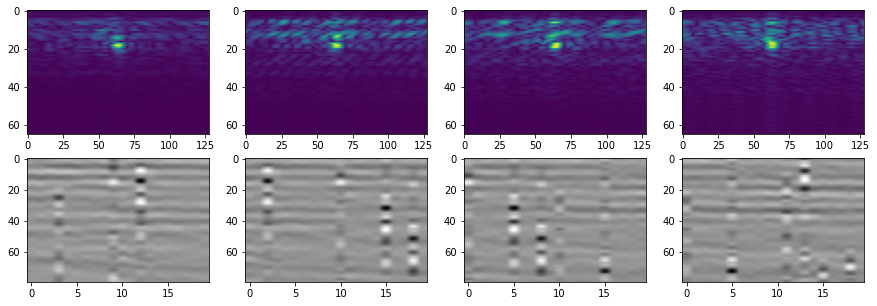

In [24]:
# Extract single CRG of pseudodeblended
crg_pseudo = pseudodeblended_data[:, 40, :]

# Transform it to the Fourier domain
crg_pseudo_fk = Sop1.H * crg_pseudo.ravel()
crg_pseudo_fk = crg_pseudo_fk.reshape(dims)
crg_pseudo_fk = crg_pseudo_fk.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

# Display different patches and their equivalent fk spectrum
ix = 16
fig, axs = plt.subplots(2, 4, figsize=(15, 5))
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(crg_pseudo_fk[i, ix]).T, axes=1))
    axs[0][i].axis('tight')
    axs[1][i].imshow(np.real((Fop.H * crg_pseudo_fk[i, ix].ravel()).reshape(nwin)).T, cmap='gray')
    axs[1][i].axis('tight');

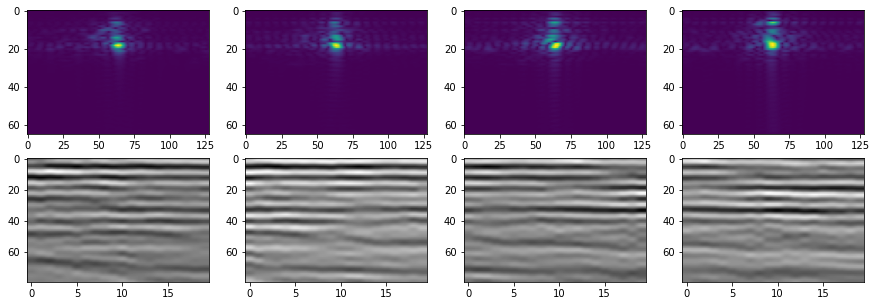

In [26]:
# Extract single CRG of deblended
crg_inv = data_inv[:, 40, :]

# Transform it to the Fourier domain
crg_inv_fk = Sop1.H * crg_inv.ravel()
crg_inv_fk = crg_inv_fk.reshape(dims)
crg_inv_fk = crg_inv_fk.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

# Display different patches and their equivalent fk spectrum
ix = 16
fig, axs = plt.subplots(2, 4, figsize=(15, 5))
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(crg_inv_fk[i, ix]).T, axes=1))
    axs[0][i].axis('tight')
    axs[1][i].imshow(np.real((Fop.H * crg_inv_fk[i, ix].ravel()).reshape(nwin)).T, cmap='gray')
    axs[1][i].axis('tight');

And the error as function of iterations with a close-up from a single patch pre and post deblending.

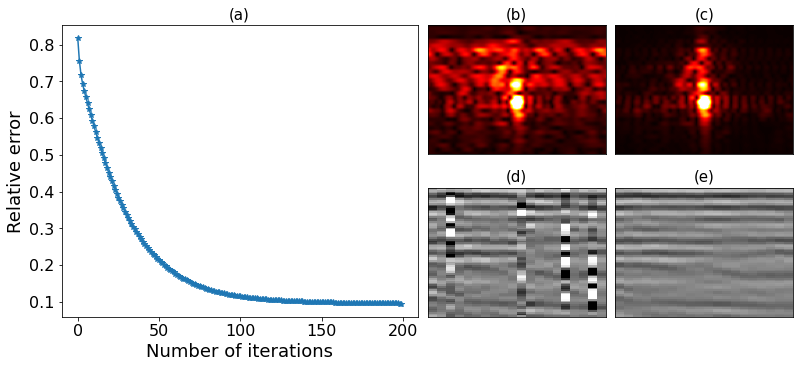

In [55]:
fig = plt.figure(figsize=(11, 5), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec2[0:2, 0:2])
ax2 = fig.add_subplot(spec2[0, 2])
ax3 = fig.add_subplot(spec2[0, 3])
ax4 = fig.add_subplot(spec2[1, 2])
ax5 = fig.add_subplot(spec2[1, 3])

ax1.plot(error, '*-')
ax1.set_xlabel('Number of iterations', fontsize=18)
ax1.set_ylabel('Relative error', fontsize=18)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_title('(a)', fontsize=15);


ix = 16
ax2.imshow(np.fft.fftshift(np.abs(crg_pseudo_fk[0, ix]).T, axes=1), vmin=0, vmax=30, cmap='hot')
ax2.axis('tight')
ax2.set_title('(b)', fontsize=15)
ax2.set_ylim(30,0)
ax3.imshow(np.fft.fftshift(np.abs(crg_inv_fk[0, ix]).T, axes=1), vmin=0, vmax=30, cmap='hot')
ax3.axis('tight')
ax3.set_title('(c)', fontsize=15)
ax3.set_ylim(30,0)
ax4.imshow(np.real((Fop.H * crg_pseudo_fk[1, ix].ravel()).reshape(nwin)).T, cmap='gray', 
        vmin=-30,
        vmax=30,
        interpolation="none")
ax4.axis('tight');
ax4.set_title('(d)', fontsize=15)
ax5.imshow(np.real((Fop.H * crg_inv_fk[1, ix].ravel()).reshape(nwin)).T, cmap='gray', 
        vmin=-30,
        vmax=30,
        interpolation="none")
ax5.axis('tight')
ax5.set_title('(e)', fontsize=15);

for ax in (ax2, ax3, ax4, ax5):
    ax.set_xticks([])
    ax.set_yticks([])

Finally we compute the total RMSE of deblending by inversion

In [57]:
error_deblended = np.linalg.norm(data_inv.ravel() - data.ravel()) / np.linalg.norm(data.ravel())
print(f'Total RMSE:{error_deblended}')

Total RMSE:0.09529635363390995
